# Stacked LSTM regression

In [1]:
# Suppress warnings 
import warnings,os
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress INFO and WARNING messages

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
import tensorflow as tf
tf.random.set_seed(0)
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
TRAIN_RANGE = (datetime.datetime(2015, 5, 27), datetime.datetime(2018, 5, 22))
VALID_RANGE = (datetime.datetime(2018, 5, 23), datetime.datetime(2019, 5, 22))
TEST_RANGE = (datetime.datetime(2019, 5, 23), datetime.datetime(2020, 5, 22))
TIMESTEPS = 12  # Input 12 months to predict next month

## 1. Read in dataset

In [ ]:
data = pd.read_csv('Timeseries Analysis/AAPL.csv')

In [6]:
import datetime

def str_to_datetime(s):
    # If already a datetime or date, return as-is
    if isinstance(s, (datetime.datetime, datetime.date)):
        return s
    
    # Otherwise, parse from string
    date_part = s.split(' ')[0]
    year, month, day = map(int, date_part.split('-'))
    return datetime.datetime(year=year, month=month, day=day)
data=data[['date','close']]
data.rename(columns={'close':'stock_price'},inplace=True)
data['date']=data['date'].apply(str_to_datetime)
data['date']
data.index = data.pop('date')  # Set datetime index
data.head()

,stock_price
date,
2015-05-27,132.045
2015-05-28,131.780
2015-05-29,130.280
2015-06-01,130.535
2015-06-02,129.960


<Axes: title={'center': 'Daily Apple Stock Prices'}, xlabel='date'>

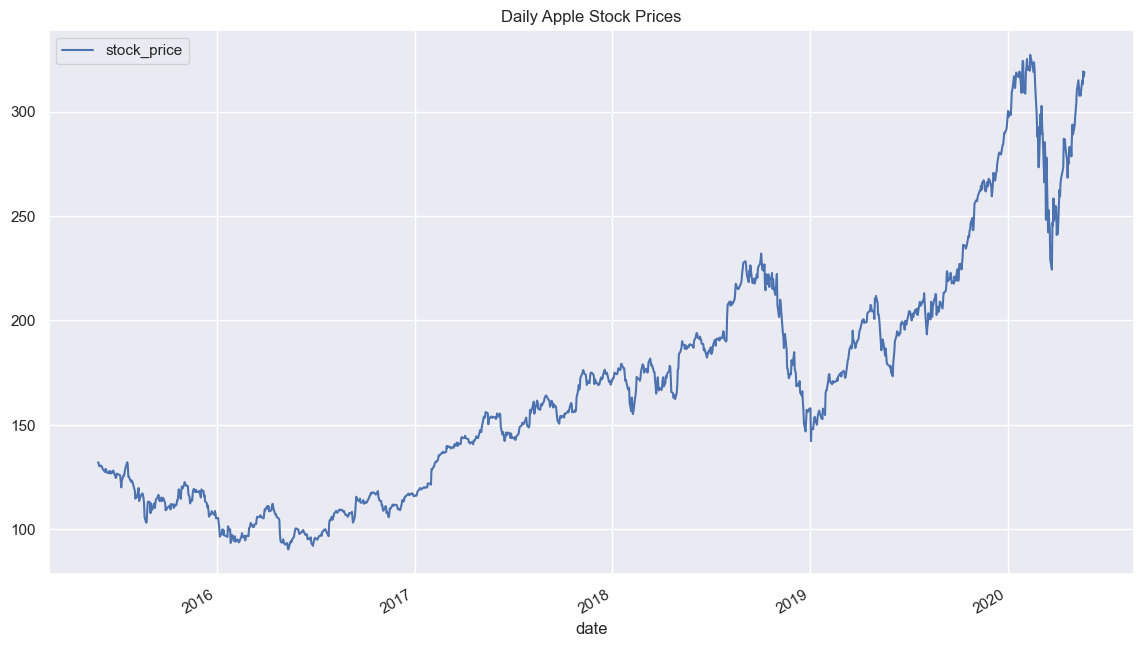

In [7]:
data.plot(figsize=(14, 8), title='Daily Apple Stock Prices')

## 2.1 Normalize dataset

<Axes: title={'center': 'Daily Normalized Apple Stock Prices'}, xlabel='date'>

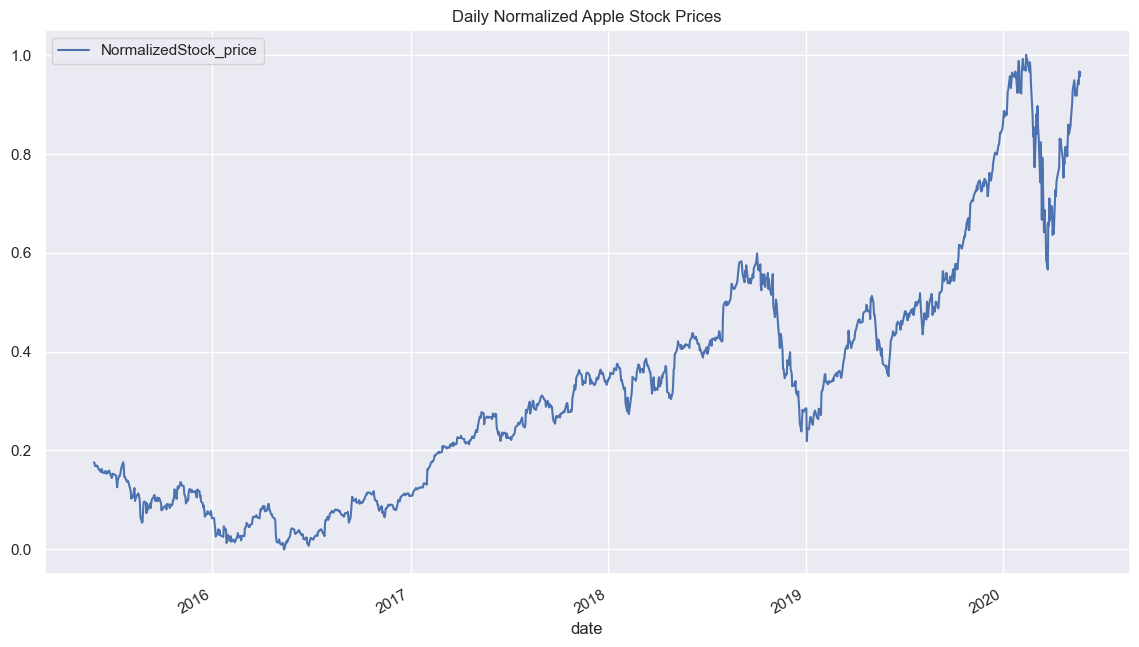

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['NormalizedStock_price'] = scaler.fit_transform(data['stock_price'].values.reshape(-1, 1)).flatten()
data[['NormalizedStock_price']].plot(figsize=(14, 8), title='Daily Normalized Apple Stock Prices')

## 2.2 Preprocess dataset

In [10]:
def create_dataset(data, timesteps=TIMESTEPS):
    """Create input and output pairs for training lstm.
    Params:
        data (pandas.DataFrame): Normalized dataset
        timesteps (int, default: TIMESTEPS): Input time length 
    Returns:
        X (numpy.array): Input for lstm
        y (numpy.array): Output for lstm
        y_date (list): Datetime of output
        start_values (list): Start valeus of each input
    """
    X, y, y_date, start_values = [], [], [], []
    
    for i in range(len(data) - timesteps):
        Xt = data.iloc[i:i+timesteps].values
        yt = data.iloc[i+timesteps]
        yt_date = data.index[i+timesteps].to_pydatetime()
        
        # Subtract a start value from each values in the timestep.
        start_value = Xt[0]
        Xt = Xt - start_value
        yt = yt - start_value
        
        X.append(Xt)
        y.append(yt)
        y_date.append(yt_date)
        start_values.append(start_value)
        
    return np.array(X), np.array(y), y_date, start_values

In [11]:
def split_train_valid_test(X, y, y_date, train_range=TRAIN_RANGE, valid_range=VALID_RANGE, test_range=TEST_RANGE):
    """Split X and y into train, valid, and test periods.
    Params:
        X (numpy.array): Input for lstm
        y (numpy.array): Output for lstm
        y_date (list): Datetime of output
        train_range (tuple): Train period
        valid_range (tuple): Validation period
        test_range (tuple): Test period
    Returns:
        X_train (pandas.DataFrame)
        X_valid (pandas.DataFrame)
        X_test (pandas.DataFrame)
        y_train (pandas.DataFrame)
        y_valid (pandas.DataFrame)
        y_test (pandas.DataFrame)
        y_date_train (list)
        y_date_valid (list)
        y_date_test (list)
    """
    train_end_idx = y_date.index(train_range[1])
    valid_end_idx = y_date.index(valid_range[1])
    
    X_train = X[:train_end_idx+1, :]
    X_valid = X[train_end_idx+1:valid_end_idx+1, :]
    X_test = X[valid_end_idx+1:, :]
    
    y_train = y[:train_end_idx+1]
    y_valid = y[train_end_idx+1:valid_end_idx+1]
    y_test = y[valid_end_idx+1:]
    
    y_date_train = y_date[:train_end_idx+1]
    y_date_valid = y_date[train_end_idx+1:valid_end_idx+1]
    y_date_test = y_date[valid_end_idx+1:]
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test

In [12]:
# Create input and output pairs for training lstm.
X, y, y_date, start_values = create_dataset(data[['NormalizedStock_price']])

# Split X and y into train, valid, and test periods.
X_train, X_valid, X_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test = split_train_valid_test(X, y, y_date)

In [13]:
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(742, 12, 1) (251, 12, 1) (253, 12, 1)
(742, 1) (251, 1) (253, 1)


## 3. Create stacked LSTM regression model

In [16]:
def create_model(timesteps=TIMESTEPS):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(timesteps, 1), name='lstm_1'))  # Input timesteps months with scalar value.
    model.add(LSTM(32, name='lstm_2'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(learning_rate=0.01), metrics=['mean_absolute_error'])
    return model

In [17]:
# Create model
model = create_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 12, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,201 (340.63 KB)

 Trainable params: 87,201 (340.63 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Callbacks of training.
es = EarlyStopping(monitor='val_mean_absolute_error', min_delta=0, patience=15, verbose=1, mode='auto')
fn = 'trained_model.keras'
mc = ModelCheckpoint(filepath=fn, save_best_only=True)
callbacks = [es, mc]

In [19]:
# Start training model.
fit = model.fit(
    X_train, y_train, 
    batch_size=32,
    epochs=1000, 
    verbose=2,
    validation_data=(X_valid, y_valid), 
    callbacks=callbacks)

Epoch 1/1000


24/24 - 6s - 230ms/step - loss: 0.0020 - mean_absolute_error: 0.0297 - val_loss: 0.0012 - val_mean_absolute_error: 0.0252
Epoch 2/1000
24/24 - 1s - 23ms/step - loss: 2.6551e-04 - mean_absolute_error: 0.0122 - val_loss: 5.0135e-04 - val_mean_absolute_error: 0.0164
Epoch 3/1000
24/24 - 0s - 19ms/step - loss: 2.1670e-04 - mean_absolute_error: 0.0114 - val_loss: 3.8399e-04 - val_mean_absolute_error: 0.0143
Epoch 4/1000
24/24 - 0s - 19ms/step - loss: 1.2147e-04 - mean_absolute_error: 0.0081 - val_loss: 3.2820e-04 - val_mean_absolute_error: 0.0134
Epoch 5/1000
24/24 - 0s - 19ms/step - loss: 1.1204e-04 - mean_absolute_error: 0.0078 - val_loss: 3.0507e-04 - val_mean_absolute_error: 0.0129
Epoch 6/1000
24/24 - 0s - 19ms/step - loss: 1.0047e-04 - mean_absolute_error: 0.0073 - val_loss: 2.8379e-04 - val_mean_absolute_error: 0.0124
Epoch 7/1000
24/24 - 0s - 20ms/step - loss: 9.2064e-05 - mean_absolute_error: 0.0069 - val_loss: 2.6918e-04 - val_mean_absolute_error: 0.0119
Epoch 8/1000
24/24 - 1s - 

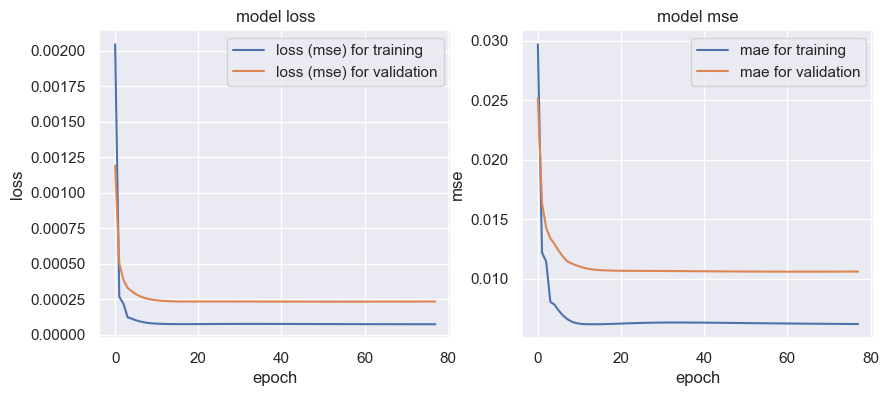

In [20]:
# Plot training history
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10, 4))
axL.plot(fit.history['loss'], label="loss (mse) for training")
axL.plot(fit.history['val_loss'], label="loss (mse) for validation")
axL.set_title('model loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.legend(loc='upper right')

axR.plot(fit.history['mean_absolute_error'], label="mae for training")
axR.plot(fit.history['val_mean_absolute_error'], label="mae for validation")
axR.set_title('model mse')
axR.set_xlabel('epoch')
axR.set_ylabel('mse')
axR.legend(loc='upper right')

plt.show()

# Load best model
model = load_model(fn)

In [21]:
def evaluate_model(data, scaler, X_train, X_valid, X_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test, start_values, model):
    """Evaluate trained model by rmse (root mean squared error) and mae (mean absolute error)'"""
    
    # Predict next month passengers
    pred_train = model.predict(X_train)
    pred_valid = model.predict(X_valid)
    pred_test = model.predict(X_test)
    
    # Add start_values that were subtracted when preprocessing.
    pred_train  = pred_train + start_values[:len(X_train)]
    pred_valid  = pred_valid + start_values[len(X_train):len(X_train)+len(X_valid)]
    pred_test  = pred_test + start_values[len(X_train)+len(X_valid):]
    
    # Inverse transform normalization
    pred_train = scaler.inverse_transform(pred_train).flatten()
    pred_valid = scaler.inverse_transform(pred_valid).flatten()
    pred_test = scaler.inverse_transform(pred_test).flatten()
    
    pred_df = data.copy()
    pred_df.loc[y_date_train[0]:y_date_train[-1], 'PredictionTrain'] = pred_train
    pred_df.loc[y_date_valid[0]:y_date_valid[-1], 'PredictionValid'] = pred_valid
    pred_df.loc[y_date_test[0]:y_date_test[-1], 'PredictionTest'] = pred_test
    pred_df[['stock_price', 'PredictionTrain', 'PredictionValid', 'PredictionTest']].plot(figsize=(12, 6), title='Predicted Apple Stock Prices')
    fig.show()
    
    # Add start_values that were subtracted when preprocessing.
    y_train  = y_train + start_values[:len(X_train)]
    y_valid  = y_valid + start_values[len(X_train):len(X_train)+len(X_valid)]
    y_test  = y_test + start_values[len(X_train)+len(X_valid):]
    
    # Inverse transform normalization
    y_train = scaler.inverse_transform(y_train).flatten()
    y_valid = scaler.inverse_transform(y_valid).flatten()
    y_test = scaler.inverse_transform(y_test).flatten()
    
    # Evaluate prediction scores of model.
    for y, pred, mode in zip([y_train, y_valid, y_test], [pred_train, pred_valid, pred_test], ['train', 'valid', 'test']):
        rmse = np.sqrt(mean_squared_error(y, pred))
        mae = mean_absolute_error(y, pred)
        print(f'{mode} rmse: {rmse:.06f}, mae: {mae:.06f}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
train rmse: 1.910920, mae: 1.344780
valid rmse: 3.606402, mae: 2.512054
test rmse: 6.480187, mae: 4.313686


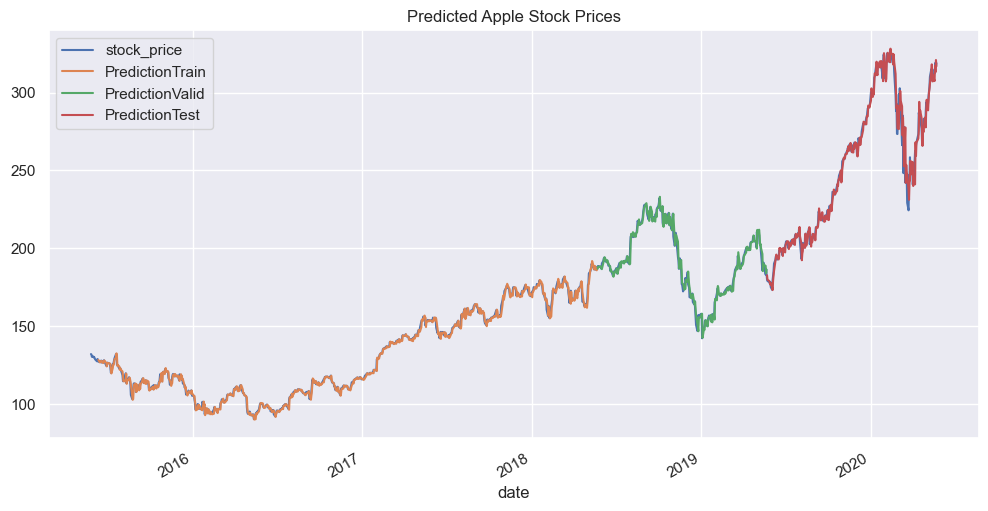

In [22]:
evaluate_model(data, scaler, X_train, X_valid, X_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test, start_values, model)